In [2]:
import sys
import math
import matplotlib.pyplot as plt
import wordcloud
from pyspark.sql import SparkSession
from pyspark import SparkConf
import pyspark
import os
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType, ArrayType
import multidict

In [3]:
'''
spark = SparkSession.builder \
        .master("yarn") \
        .appName("HelloLines") \
        .getOrCreate()
sc = spark.sparkContext
rdd = sc.textFile("hdfs:/user/cunha/hello.txt")
'''
os.environ["JAVA_HOME"] = "/home/luizcouto/Apps/jdk-8"
os.environ["HADOOP_INSTALL"] = "/home/luizcouto/Apps/hadoop-2.7.3"
os.environ["HADOOP_HOME"] = os.environ["HADOOP_INSTALL"]
os.environ["HADOOP_MAPRED_HOME"] = os.environ["HADOOP_INSTALL"]
os.environ["HADOOP_COMMON_HOME"] = os.environ["HADOOP_INSTALL"]
os.environ["HADOOP_HDFS_HOME"] = os.environ["HADOOP_INSTALL"]
os.environ["HADOOP_YARN_HOME"] = os.environ["HADOOP_INSTALL"]
os.environ["HADOOP_CONF_DIR"] = os.path.join(os.environ["HADOOP_INSTALL"], "/etc/hadoop")

table_schema = StructType([
    StructField("hashtag", StringType(), True),
    StructField("popularity",   IntegerType(), True),
    StructField("correlated", StringType(), True),
])

spark = SparkSession \
    .builder \
    .enableHiveSupport() \
    .config(conf=SparkConf().set("spark.driver.maxResultSize", "2g")) \
    .appName("wordcloudmapp") \
    .getOrCreate()

path = "../../out/"
df = spark.read.csv(path, schema=table_schema)
df.show()




22/05/12 01:10:04 WARN Utils: Your hostname, luizcouto-X510URR resolves to a loopback address: 127.0.1.1; using 192.168.1.106 instead (on interface wlp2s0)
22/05/12 01:10:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/12 01:10:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+--------------------+----------+--------------------+
|             hashtag|popularity|          correlated|
+--------------------+----------+--------------------+
|                 #19|         1|#mentalwellness,#...|
|              #28Mar|         1|#VirgenMaría,#Cov...|
|#60AniversarioISSSTE|         1|#MéxicoUnido,#Qué...|
|#ActivadosPorLa-S...|         1|#QuédateEnCasa,#J...|
|#ActivadosPorLaSalud|         3|#QuédateEnCasa,#C...|
| #BandasSinApellidos|         1|#LaMúsicaEnseñaVa...|
| #BersamaLawanCorona|         1|#HidupSehattvOne,...|
|          #Bolsonaro|         1|#PandemiaCoronavi...|
|             #Brasil|         1|                null|
|            #COVID19|        67|#Coronavirus,#COV...|
|   #COVID19Indonesia|         1|#HidupSehattvOne,...|
|   #COVID19argentina|         1|#blogdeviajes,#ar...|
|          #COVID19😷|         1|         #OpiniónLSR|
|          #COVID19🦠|         1|#MéxicoUnido,#Qué...|
|          #COVID2019|         1|            #COVID19|
|           

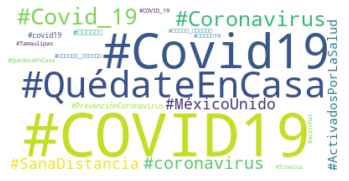

In [5]:
ordered = df.orderBy("popularity", ascending=False)
ordered = ordered.limit(50)

word_cloud_dict = multidict.MultiDict()
degrees_histogram = []
data_collect = ordered.rdd.toLocalIterator()
for row in data_collect:
    # 1.1
    word_cloud_dict.add(str(row.hashtag), math.log2(int(row.popularity)))


wc = wordcloud.WordCloud(background_color="white", max_words=500)
wc.generate_from_frequencies(word_cloud_dict)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()